# Classifying CMU Face Images

This model is overfitting because I'm training on the same images with different sizes.

# Load libraries

In [21]:
import os
import cv2
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [2]:
import torch
import torch.nn as nn
import torchvision.utils 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Check for MPS (Apple Silicon), CUDA (for Nvidia GPUs), or fallback to CPU

We're checking for different device options (MPS, CUDA, or CPU) to ensure that our PyTorch model runs on the most powerful hardware available. Running on a GPU (like CUDA or MPS) significantly speeds up computations, especially for tasks involving large datasets or deep learning models, by performing parallel processing. If no GPU is available, the code falls back to using the CPU, which is slower but still functional.

On Mac, newer Apple Silicon chips (M1/M2) support GPU acceleration through Metal Performance Shaders (MPS), which we check for to optimize performance.

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Metal Performance Shaders for Mac
elif torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA for Nvidia GPUs (if available on Mac)
else:
    device = torch.device('cpu')   # Fallback to CPU

print(f'Using device: {device}')

Using device: mps


# Define the LeNet-5 architecture

We switched the original 10 output features to 20 in the final fully connected layer because the number of output neurons must match the number of classes in your dataset. The original model had 10 output neurons, suitable for datasets like MNIST with 10 classes. Since your dataset has 20 classes, we need 20 output neurons, with each neuron representing one class, allowing the model to output a score for each of the 20 possible classes.

In [4]:
# Define the LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional layer 1: 1 input channel (for grayscale images), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Subsampling layer (MaxPooling) with 2x2 kernel and stride 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Subsampling layer (MaxPooling) with 2x2 kernel and stride 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16*5*5, 120)
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 84 input features, 20 output features for 20 classes (modified from original LeNet5)
        self.fc3 = nn.Linear(84, 20)

        # Activation function: ReLU will be used
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape of the image is assumed to be [batch_size, 1, 32, 32]

        # Pass the input through the first convolutional layer, then activation, then pool
        x = self.pool1(self.relu(self.conv1(x)))
        # Pass the output through the second convolutional layer, then activation, then pool
        x = self.pool2(self.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pass the flattened output through the first fully connected layer, then activation
        x = self.relu(self.fc1(x))
        # Pass the output through the second fully connected layer, then activation
        x = self.relu(self.fc2(x))
        # Pass the output through the final output layer
        x = self.fc3(x)

        return x

In [5]:
# Instantiate the network
lenet5 = LeNet5().to(device)

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [7]:
# Optimizer (SGD is used in the original paper)
optimizer = optim.SGD(lenet5.parameters(), lr=0.001, momentum=0.9)

# Loading our data

We should resize the images to be 32x32 because the original LeNet-5 architecture expects input images of size 32x32, as it was originally designed for the MNIST dataset, where images have that specific resolution.

In [8]:
# Dataset transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

In [9]:
# Load dataset
data = ImageFolder(root='./faces/', transform=transform)

In [10]:
print(f"There are {len(data.classes)} classes.")
print(data.classes)

There are 20 classes.
['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']


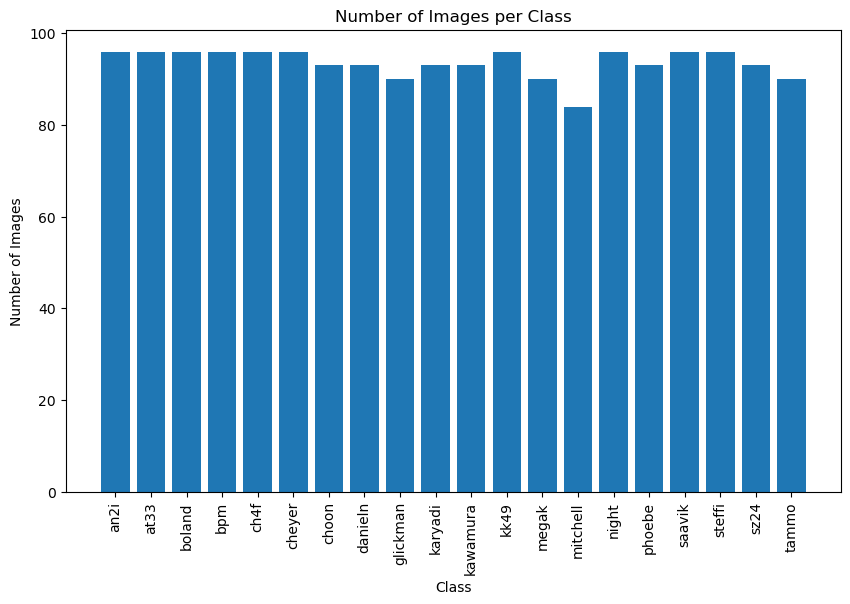

In [19]:
# Get all the labels (targets) from the dataset
labels = [label for _, label in data]

# Count the occurrences of each label
label_counts = Counter(labels)

# Get the class names and the corresponding counts
class_names = data.classes
counts = [label_counts[i] for i in range(len(class_names))]

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [11]:
def visualize_random_images(dataset, num_images=5):
    """
    Visualizes a specified number of random images from the dataset and shows their labels.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    indices = random.sample(range(len(dataset)), num_images)
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        image = image.numpy().transpose((1, 2, 0))
        image = image * 0.5 + 0.5  # Unnormalize the image

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.show()

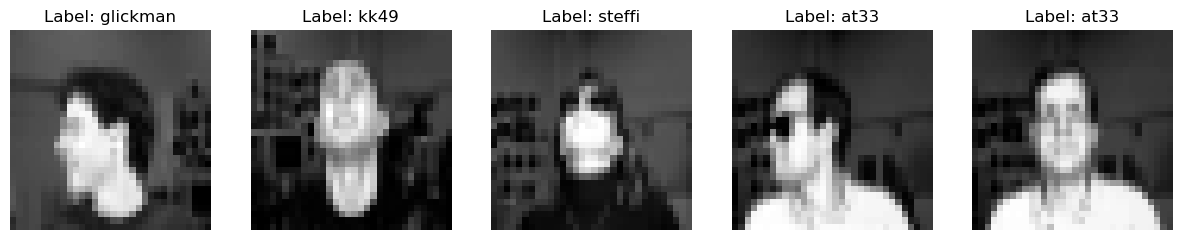

In [12]:
visualize_random_images(data)

In [13]:
# Split dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Training set: {len(train_data)}, Testing set: {len(test_data)}")

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Training set: 1497, Testing set: 375


# Train the model

In [15]:
print(f'Number of batches per epoch: {len(train_loader)}')

Number of batches per epoch: 24


In [16]:
%%time
num_epochs = 100 # Number of epochs
print_interval = 20  # Print every n batches


for epoch in range(num_epochs):
    lenet5.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Loop through the training batches
    for i, (images, labels) in enumerate(train_loader, 0):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients for proper weight updates

        # Forward pass
        outputs = lenet5(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / print_interval:.6f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/100], Step [20/24], Loss: 2.998597
Epoch [2/100], Step [20/24], Loss: 2.998710
Epoch [3/100], Step [20/24], Loss: 2.996776
Epoch [4/100], Step [20/24], Loss: 2.997401
Epoch [5/100], Step [20/24], Loss: 2.997034
Epoch [6/100], Step [20/24], Loss: 2.994904
Epoch [7/100], Step [20/24], Loss: 2.995545
Epoch [8/100], Step [20/24], Loss: 2.995459
Epoch [9/100], Step [20/24], Loss: 2.994329
Epoch [10/100], Step [20/24], Loss: 2.993358
Epoch [11/100], Step [20/24], Loss: 2.992710
Epoch [12/100], Step [20/24], Loss: 2.993079
Epoch [13/100], Step [20/24], Loss: 2.992284
Epoch [14/100], Step [20/24], Loss: 2.991462
Epoch [15/100], Step [20/24], Loss: 2.989820
Epoch [16/100], Step [20/24], Loss: 2.990838
Epoch [17/100], Step [20/24], Loss: 2.989490
Epoch [18/100], Step [20/24], Loss: 2.989110
Epoch [19/100], Step [20/24], Loss: 2.986424
Epoch [20/100], Step [20/24], Loss: 2.986846
Epoch [21/100], Step [20/24], Loss: 2.984920
Epoch [22/100], Step [20/24], Loss: 2.984964
Epoch [23/100], Ste

# Evaluating the model

In [24]:
def evaluate_model(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())    

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Macro F1 Score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 99.93%
Macro F1 Score: 0.9993


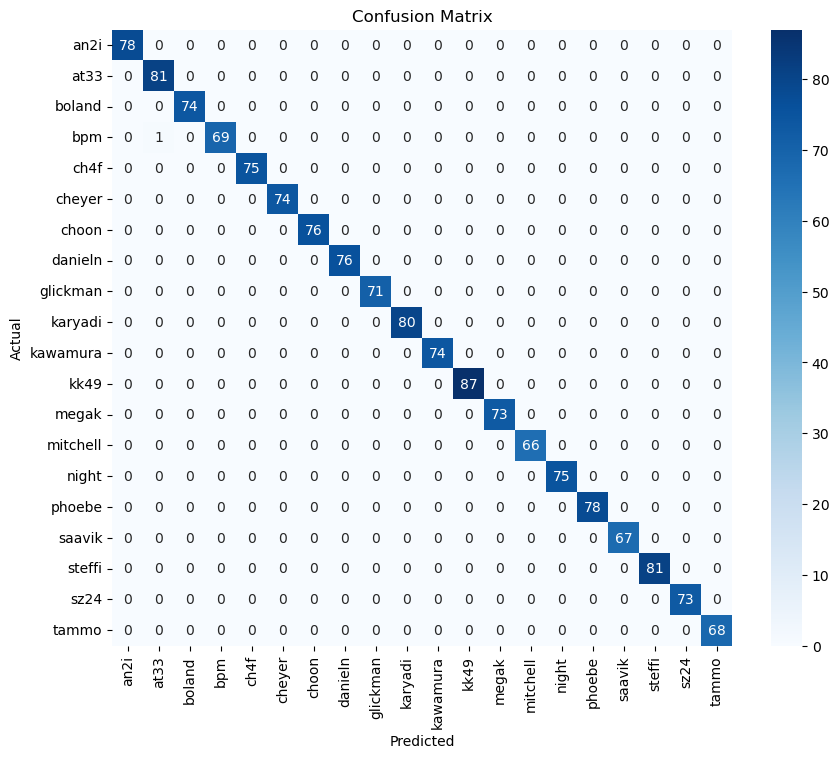

In [25]:
# Evaluate on the training set
evaluate_model(lenet5, train_loader, device, data.classes)

Accuracy: 99.20%
Macro F1 Score: 0.9924


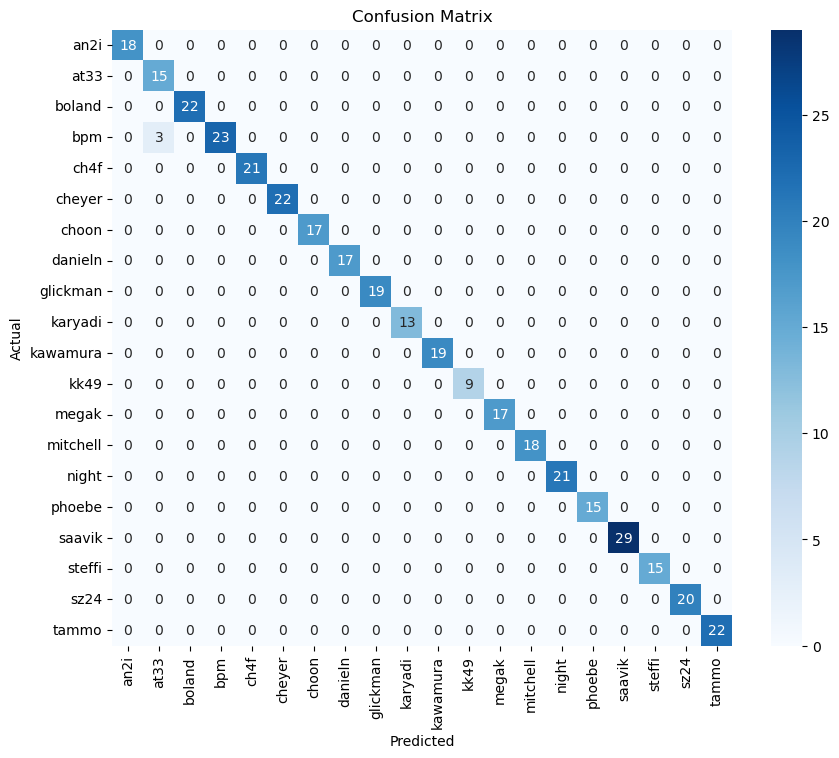

In [26]:
# Evaluate on the test set
evaluate_model(lenet5, test_loader, device, data.classes)